In [8]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'sagemaker-20190314'

In [4]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 801 ms, sys: 307 ms, total: 1.11 s
Wall time: 3.23 s


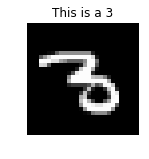

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [9]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

# bucket = 'bucket-name' # Use the name of your s3 bucket here
data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://sagemaker-20190314/kmeans_lowlevel_example/data
CPU times: user 8.77 s, sys: 331 ms, total: 9.1 s
Wall time: 9.45 s


In [10]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-20190314/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-20190314/kmeans_highlevel_example/output


In [11]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2019-03-14-17-58-36-539


2019-03-14 17:58:36 Starting - Starting the training job...
2019-03-14 17:58:38 Starting - Launching requested ML instances......
2019-03-14 17:59:44 Starting - Preparing the instances for training...
2019-03-14 18:00:22 Downloading - Downloading input data...
2019-03-14 18:01:05 Training - Training image download completed. Training in progress.
2019-03-14 18:01:05 Uploading - Uploading generated training model
2019-03-14 18:01:05 Completed - Training job completed

Docker entrypoint called with argument(s): train
[03/14/2019 18:00:51 INFO 140709325694784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_l

Billable seconds: 88
CPU times: user 8.01 s, sys: 478 ms, total: 8.49 s
Wall time: 2min 51s


In [12]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2019-03-14-18-01-37-722
INFO:sagemaker:Creating endpoint with name kmeans-2019-03-14-17-58-36-539


---------------------------------------------------------------------------!CPU times: user 372 ms, sys: 23.2 ms, total: 395 ms
Wall time: 6min 20s


In [13]:
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.788968086242676
    }
  }
}
]


In [14]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 34.9 ms, sys: 89 µs, total: 35 ms
Wall time: 215 ms





Cluster 0:


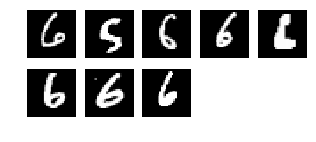




Cluster 1:


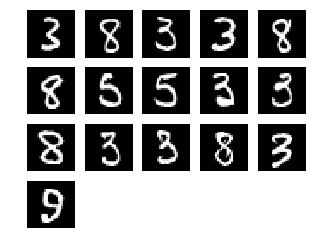




Cluster 2:


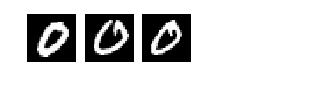




Cluster 3:


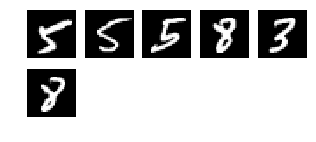




Cluster 4:


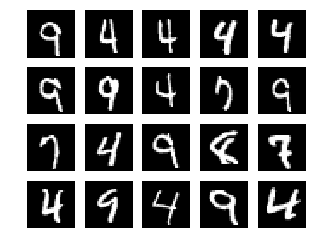




Cluster 5:


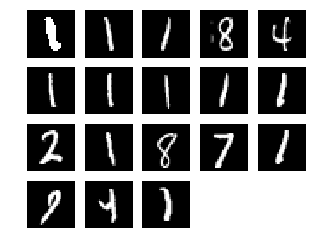




Cluster 6:


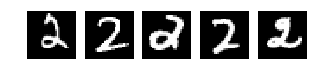




Cluster 7:


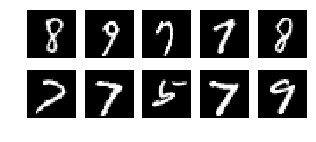




Cluster 8:


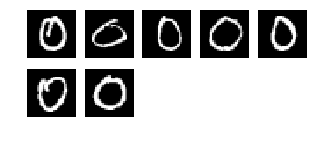




Cluster 9:


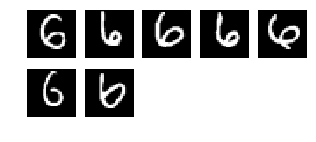

In [15]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()